In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

### **Dataset Preparation**

- Check if the missing values are presented in the features.
- If there are missing values:
    - For caterogiral features, replace them with 'NA'
    - For numerical features, replace with with 0.0

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [2]:
df = pd.read_csv("course_lead_scoring.csv")
df.sample(5)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
744,events,education,3,42819.0,employed,north_america,3,0.70,1
1290,NaN,healthcare,2,50302.0,unemployed,europe,4,0.61,1
83,paid_ads,technology,1,82346.0,student,africa,2,0.60,0
713,referral,retail,0,68914.0,unemployed,africa,4,0.96,1
91,organic_search,NaN,0,63020.0,employed,north_america,2,0.37,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [5]:
df.isnull().any()

lead_source                  True
industry                     True
number_of_courses_viewed    False
annual_income                True
employment_status            True
location                     True
interaction_count           False
lead_score                  False
converted                   False
dtype: bool

In [7]:
df[['lead_source', 'industry', 'employment_status', 'location']] = df[['lead_source', 'industry', 'employment_status', 'location']].fillna('NA')
df['annual_income'] = df['annual_income'].fillna(0.0)

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

print(len(df), len(df_train), len(df_val), len(df_test))
assert len(df) == len(df_train) + len(df_val) + len(df_test)

1462 876 293 293


In [9]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

### **Question 1: ROC AUC feature importance**

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
- Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

In [10]:
from sklearn.metrics import roc_auc_score

In [11]:
num_features = df.select_dtypes(include='number').columns[:-1]

In [13]:
auc_scores = {}

for feature in num_features:
    score = roc_auc_score(df_train['converted'], df_train[feature])

    if score < 0.5:
        score = roc_auc_score(df_train['converted'], -df_train[feature])

    auc_scores[feature] = score

highest_auc = max(auc_scores, key=auc_scores.get)
print(f"The highest AUC of numerical variable: {highest_auc}")

The highest AUC of numerical variable: number_of_courses_viewed


### **Question 2: Training the model**

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

In [39]:
y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values

In [40]:
X_train = df_train.iloc[:, :-1]
X_val = df_val.iloc[:, :-1]
X_test = df_test.iloc[:, :-1]

In [41]:
dv = DictVectorizer(sparse=False)

In [42]:
dict_train = X_train.to_dict(orient='records')
dict_val = X_val.to_dict(orient='records')
dict_test = X_test.to_dict(orient='records')

In [43]:
dv.fit(dict_train)

,dtype,<class 'numpy.float64'>
,separator,'='
,sparse,False
,sort,True


In [44]:
dv.get_feature_names_out()

array(['annual_income', 'employment_status=NA',
       'employment_status=employed', 'employment_status=self_employed',
       'employment_status=student', 'employment_status=unemployed',
       'industry=NA', 'industry=education', 'industry=finance',
       'industry=healthcare', 'industry=manufacturing', 'industry=other',
       'industry=retail', 'industry=technology', 'interaction_count',
       'lead_score', 'lead_source=NA', 'lead_source=events',
       'lead_source=organic_search', 'lead_source=paid_ads',
       'lead_source=referral', 'lead_source=social_media', 'location=NA',
       'location=africa', 'location=asia', 'location=australia',
       'location=europe', 'location=middle_east',
       'location=north_america', 'location=south_america',
       'number_of_courses_viewed'], dtype=object)

In [45]:
X_train = dv.transform(dict_train)
X_val = dv.transform(dict_val)
X_test = dv.transform(dict_test)

In [46]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [47]:
y_pred = model.predict_proba(X_val)[:, 1]

auc_score_val = roc_auc_score(y_val, y_pred)

In [48]:
print(f"The AUC of this model on the validation dataset: {auc_score_val:.3f}")

The AUC of this model on the validation dataset: 0.817


### **Question 3: Precision and Recall**

Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

In [49]:
# Compute precision and recall for the model
thresholds = np.linspace(0, 1, 101)
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
scores = []

for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (actual_positive & predict_positive).sum()
    tn = (actual_negative & predict_negative).sum()
    fp = (actual_negative & predict_positive).sum()
    fn = (actual_positive & predict_negative).sum()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    scores.append((t, tp, tn, fp, fn, precision, recall))

C:\Users\rluka\AppData\Local\Temp\ipykernel_10988\977507988.py:14: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


In [50]:
# Define a dataframe of scores
columns = ['thresholds', 'tp', 'tn', 'fp', 'fn', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,thresholds,tp,tn,fp,fn,precision,recall
0,0.00,171,0,122,0,0.583618,1.000000
1,0.01,171,0,122,0,0.583618,1.000000
2,0.02,171,0,122,0,0.583618,1.000000
3,0.03,171,0,122,0,0.583618,1.000000
4,0.04,171,0,122,0,0.583618,1.000000
...,...,...,...,...,...,...,...
96,0.96,3,122,0,168,1.000000,0.017544
97,0.97,1,122,0,170,1.000000,0.005848
98,0.98,0,122,0,171,NaN,0.000000
99,0.99,0,122,0,171,NaN,0.000000


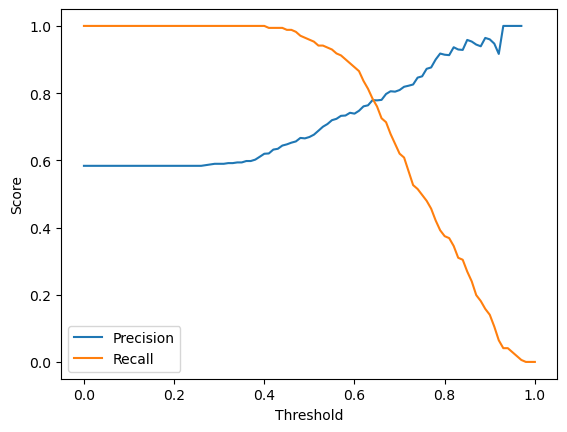

In [51]:
# Plot the thresholds by precision and recall to identify the intersection of precision and recall
plt.plot(df_scores['thresholds'], df_scores['precision'], label='Precision')
plt.plot(df_scores['thresholds'], df_scores['recall'], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()

In [52]:
print("The threshold precision and recall curves intersect at 0.745")

The threshold precision and recall curves intersect at 0.745


### **Question 4: F1 score**

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

In [53]:
# Compute F1 score for all thresholds from 0.0 to 1.0 with increment 0.01
thresholds = np.linspace(0, 1, 101)
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
scores = []

for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (actual_positive & predict_positive).sum()
    tn = (actual_negative & predict_negative).sum()
    fp = (actual_negative & predict_positive).sum()
    fn = (actual_positive & predict_negative).sum()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    scores.append((t, tp, tn, fp, fn, precision, recall, f1))

C:\Users\rluka\AppData\Local\Temp\ipykernel_10988\2061402382.py:14: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


In [54]:
# Define a dataframe of scores
columns = ['thresholds', 'tp', 'tn', 'fp', 'fn', 'precision', 'recall', 'f1']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,thresholds,tp,tn,fp,fn,precision,recall,f1
0,0.00,171,0,122,0,0.583618,1.000000,0.737069
1,0.01,171,0,122,0,0.583618,1.000000,0.737069
2,0.02,171,0,122,0,0.583618,1.000000,0.737069
3,0.03,171,0,122,0,0.583618,1.000000,0.737069
4,0.04,171,0,122,0,0.583618,1.000000,0.737069
...,...,...,...,...,...,...,...,...
96,0.96,3,122,0,168,1.000000,0.017544,0.034483
97,0.97,1,122,0,170,1.000000,0.005848,0.011628
98,0.98,0,122,0,171,NaN,0.000000,NaN
99,0.99,0,122,0,171,NaN,0.000000,NaN


In [55]:
f1_max = df_scores[df_scores['f1'] == df_scores['f1'].max()]
best_threshold = f1_max['thresholds'].values[0]

print(f"The threshold with maximum F1: {best_threshold}")

The threshold with maximum F1: 0.5700000000000001


### **Question 5: 5-Fold CV**

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

```python
KFold(n_splits=5, shuffle=True, random_state=1)
```

- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: ```LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)```
- Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

In [56]:
from sklearn.model_selection import KFold

In [57]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [60]:
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train['converted'].values
    y_val = df_val['converted'].values

    df_train = df_train.iloc[:, :-1]
    df_val = df_val.iloc[:, :-1]

    dict_train = df_train.to_dict(orient='records')
    dict_val = df_val.to_dict(orient='records')

    dv.fit(dict_train)
    X_train = dv.transform(dict_train)
    X_val = dv.transform(dict_val)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

    mean_scores = np.mean(scores)
    std_scores = np.std(scores)

    print(f"{mean_scores:.3f} +- {std_scores:.3f}")

0.806 +- 0.000
0.839 +- 0.033
0.818 +- 0.040
0.814 +- 0.035
0.822 +- 0.036


In [61]:
print("The largest standard deviation of the scores across different folds is around 0.040")

The largest standard deviation of the scores across different folds is around 0.040


### **Question 6: Hyperparameter Tuning**

Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.000001, 0.001, 1]
- Initialize KFold with the same parameters as previously
- Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

In [62]:
for C in [0.000001, 0.001, 1]:
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['converted'].values
        y_val = df_val['converted'].values

        df_train = df_train.iloc[:, :-1]
        df_val = df_val.iloc[:, :-1]

        dict_train = df_train.to_dict(orient='records')
        dict_val = df_val.to_dict(orient='records')

        dv.fit(dict_train)
        X_train = dv.transform(dict_train)
        X_val = dv.transform(dict_val)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        y_pred = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

        mean_scores = np.mean(scores)
        std_scores = np.std(scores)

    print(f"C= {C}: {mean_scores:.3f} +- {std_scores:.3f}")

C= 1e-06: 0.560 +- 0.024
C= 0.001: 0.867 +- 0.029
C= 1: 0.822 +- 0.036


In [63]:
print("C=0.001 has the best mean score")

C=0.001 has the best mean score
